### Fig 4d and Supp. Fig 7: SNR sweep of methods

In [1]:
%load_ext autoreload
%autoreload 2

import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import os, re, glob


import sys, glob
[sys.path.append(f) for f in glob.glob('../utils/*')]
from plotting_utils import figSize
from hmm import HMMRecalibration
import hmm_utils
from RTI_utils import RTI
import simulation_utils 
from simulation import simulateBCIFitts


# for a reproducible result
np.random.seed(1)

fig_path = '/home/users/ghwilson/projects/nonstationarities/figures/'
data_dir = '/oak/stanford/groups/henderj/ghwilson/nonstationarities/simulator/performance/SNR/'

In [2]:
labels = ['supervised', 'HMM', 'Click HMM', 'RTI']

files  = glob.glob(os.path.join(data_dir, '*.npy'))
idxs   = [int(re.findall('_(\d+).npy', x)[0]) for x in files]
print('Missing:', np.setdiff1d(np.arange(max(idxs)), idxs))

rep_data = list()
for f in files:
    rep_data.extend(np.load(f, allow_pickle=True))


# relabel methods based on HPs:
opts = np.asarray([0.077, 0.12, 0.17, 0.24, 0.31, 0.39, 0.48])
for x in rep_data:
    # there's some small variability in SNR scores - we'll discretize into bins
    snr_val  = np.linalg.norm(x['neuralTuning'][1:, :])**2
    idx      = np.argmin(np.abs(snr_val - opts))
    x['SNR'] = opts[idx]
                    
    x['SNR_val'] = snr_val # record exact SNR too
    
    if x['method'] == 'RTI' and x['look_back'] == 500:
        x['method'] = 'RTI (long look_back)'
    
    elif x['method'] == 'PRI-T' and x['click_inflection'] != None:
        x['method'] = 'Click PRI-T'
    
    else:
        continue

df = pd.DataFrame(rep_data, columns=['ttt','method','chained', 'SNR', 'SNR_val'])
df['Trial time (sec)'] = np.vstack(df['ttt'])[:, -1]

Missing: []


<AxesSubplot: xlabel='SNR_val', ylabel='SNR'>

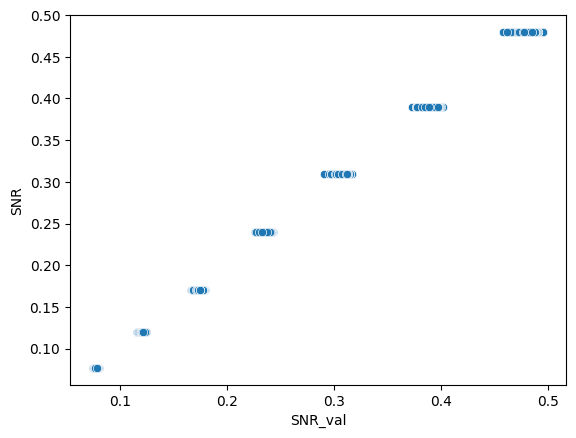

In [3]:
# just visually confirm our discretization aligns with ground-truth
sns.scatterplot(df, x='SNR_val', y='SNR')

## Vanilla HMM vs RTI comparisons

In [4]:
def makeEfficiencyPlot(df, subset_labels, colors, x = 'nSimSteps'):

    cmap      = dict(zip(subset_labels, colors))
    scores_df = df[df['method'].isin(subset_labels)]

    sns.stripplot(data = scores_df, x = x, y = 'Trial time (sec)', hue_order = subset_labels,
                  hue = 'method', alpha = 0.8, palette = cmap, dodge = True)

    ax = plt.gca()

    sns.boxplot(medianprops={'ls': '-', 'lw': 2, 'alpha' : 0.6,}, whiskerprops={'visible': False},
                zorder=1, x=x, y="Trial time (sec)", hue='method', data=scores_df, hue_order = subset_labels,
                showfliers=False, showbox=False, showcaps=False, ax=ax)

    #plt.yscale('log')
    handles, labels = ax.get_legend_handles_labels()
    plt.legend(handles[:len(subset_labels)],labels[:len(subset_labels)], frameon=False)
    ax.spines['top'].set_visible(False)
    ax.spines['right'].set_visible(False)

    return ax

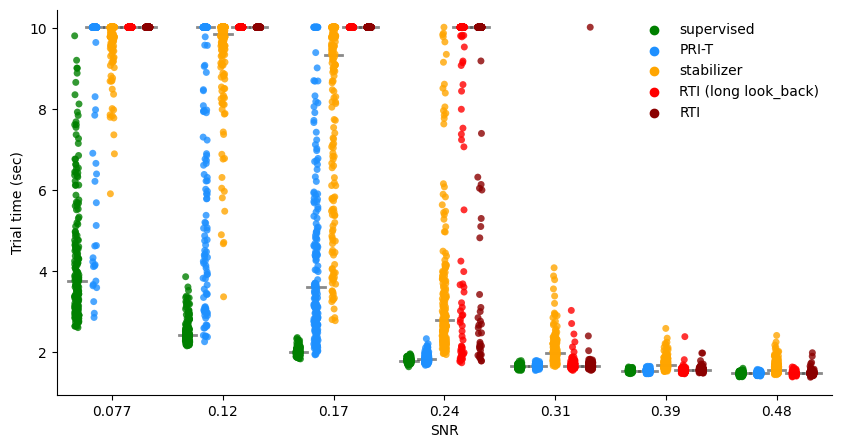

In [5]:
figSize(5, 10)

subset_labels = ['supervised', 'PRI-T', 'stabilizer', 'RTI (long look_back)', 'RTI', ]
colors = ['g', 'dodgerblue', 'orange', 'r', 'darkred', ]

makeEfficiencyPlot(df, subset_labels, colors, x = 'SNR')
plt.savefig(os.path.join(fig_path, 'simulator', 'SNR_sweep.pdf'), format = 'pdf')

<AxesSubplot: xlabel='SNR', ylabel='Trial time (sec)'>

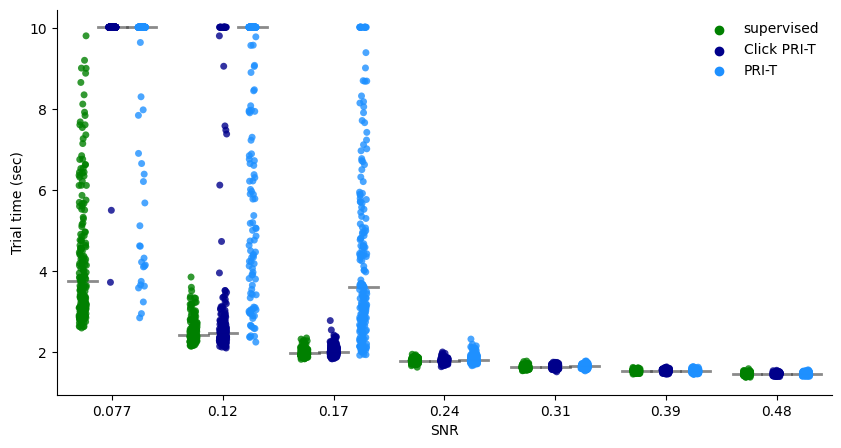

In [6]:
subset_labels = ['supervised', 'Click PRI-T', 'PRI-T']
colors = ['g', 'darkblue', 'dodgerblue', 'r']

makeEfficiencyPlot(df, subset_labels, colors, x = 'SNR')
#plt.savefig(os.path.join(fig_path, 'simulator', 'SNR_sweep_click.pdf'), format = 'pdf')

In [12]:
import scipy.stats

field = 'SNR'

subset_labels = df['method'].unique()

for nSteps in np.unique(df[field]):
    subset = df[df[field] == nSteps]
    
    print(' \n ============== ', field, ':', nSteps, '================')
    for method in subset_labels:
        times = subset.loc[subset['method'] == method, 'Trial time (sec)']
        print(f"{method:<20} Mean: {times.mean():8.3f}   Median: {times.median():8.3f}")

    print('\n')
    for i, method1 in enumerate(subset_labels):
        for j, method2 in enumerate(subset_labels):
            if i > j:
                stat = scipy.stats.ranksums(
                    subset.loc[subset['method'] == method1, 'Trial time (sec)'],
                    subset.loc[subset['method'] == method2, 'Trial time (sec)']
                )
                # Determine which method has lower values based on the sign of the statistic
                if stat[0] < 0:
                    lower = method1
                elif stat[0] > 0:
                    lower = method2
                else:
                    lower = "tie"

                print(
                    f"{method1:<20} vs {method2:<20} "
                    f"stat = {stat[0]:8.4f}   p = {stat[1]:8.4f}   lower = {lower}"
                )

 
 ==============  SNR : 0.077 ================
PRI-T                Mean:    9.441   Median:   10.020
Click PRI-T          Mean:    9.966   Median:   10.020
RTI                  Mean:   10.020   Median:   10.020
RTI (long look_back) Mean:   10.020   Median:   10.020
stabilizer           Mean:    9.736   Median:   10.020
supervised           Mean:    4.296   Median:    3.748


Click PRI-T          vs PRI-T                stat =   1.9003   p =   0.0574   lower = PRI-T
RTI                  vs PRI-T                stat =   2.0759   p =   0.0379   lower = PRI-T
RTI                  vs Click PRI-T          stat =   0.1730   p =   0.8627   lower = Click PRI-T
RTI (long look_back) vs PRI-T                stat =   2.0759   p =   0.0379   lower = PRI-T
RTI (long look_back) vs Click PRI-T          stat =   0.1730   p =   0.8627   lower = Click PRI-T
RTI (long look_back) vs RTI                  stat =   0.0000   p =   1.0000   lower = tie
stabilizer           vs PRI-T                stat =  -4.98

In [230]:
import numpy as np
from sklearn.linear_model import LinearRegression
import matplotlib.pyplot as plt

import sys, glob, os
from utils.plotting.plotting_utils import figSize
from utils.simulation.simulation import simulateBCIFitts
from utils.simulation import simulation_utils
from utils.preprocessing import sweep_utils

from utils.recalibration import RTI_utils, stabilizer_utils, hmm_utils, hmm
from stabilizer_utils import Stabilizer
from hmm import HMMRecalibration
from RTI_utils import RTI

import copy
from joblib import Parallel, delayed
import argparse





def initializeMethod(base_opts, method_opts):

    
    if method_opts['method'] == 'stabilizer':
        cfg, ss_decoder_dict, stabilizer = simulation_utils.initializeBCI({**base_opts, **method_opts})
        method = (ss_decoder_dict, stabilizer, method_opts)
        
    elif method_opts['method'] == 'RTI':
        cfg    = simulation_utils.initializeBCI(base_opts)
        method = RTI(method_opts['look_back'], method_opts['min_dist'], method_opts['min_time'])

    elif method_opts['method'] == 'PRI-T':
        cfg                     = simulation_utils.initializeBCI(base_opts)
        adjustKappa             = lambda x: 1 / (1 + np.exp(-1 * (x - method_opts['inflection']) * method_opts['exp']))
        targLocs                = hmm_utils.generateTargetGrid(gridSize = method_opts['gridSize'], is_simulated=True)
        stateTrans, pStateStart = hmm_utils.generateTransitionMatrix(gridSize = method_opts['gridSize'],
                                                                     stayProb = method_opts['stayProb'])

        if method_opts['click_inflection'] is None:
            clickModel = None
        else:
            clickModel = lambda x: 1- (1 / (1 + np.exp(-1 * (x - method_opts['click_inflection'])*12))) 
            
        method = HMMRecalibration(stateTrans, targLocs, pStateStart, method_opts['vmKappa'], 
                                          adjustKappa = adjustKappa, getClickProb = clickModel)
        
    elif method_opts['method'] == 'supervised':
        cfg    = simulation_utils.initializeBCI(base_opts)
        method = []
        
    elif method_opts['method'] == 'gain':
        cfg    = simulation_utils.initializeBCI(base_opts)
        method = []
        
    else:
        raise ValueError('Method not recognized')
        
            
    return cfg, method


def performMethodRecal(cfg, method_opts, method):
    
    if method_opts['method'] == 'stabilizer':
        D = simulation_utils.simulate_LatentClosedLoopRecalibration(cfg, *method)
        
    elif method_opts['method'] == 'RTI':
        D = simulation_utils.simulate_RTIRecalibration(cfg, method)
        
    elif method_opts['method'] == 'PRI-T':
        D = simulation_utils.simulate_HMMRecalibration(cfg, method)
        
    elif method_opts['method'] == 'supervised':
        cfg_copy      = copy.deepcopy(cfg)
        cfg_copy['D'] = simulation_utils.simulate_OpenLoopRecalibration(cfg_copy, nSteps = 10000)
        D             = simulation_utils.simulate_ClosedLoopRecalibration(cfg_copy)
        
    elif method_opts['method'] == 'gain':
        D = cfg['D']
        
    else:
        raise ValueError('Method not recognized')

        
    return D
    


def testMethod(base_opts, method_opts, save_fields = None):
    
    scores_dict = copy.deepcopy(method_opts)
    scores_dict['cfgs'] = list()
    scores_dict['test_cfgs'] = list()
    scores      = np.zeros((base_opts['n_sessions']))
    
    cfg, method = initializeMethod(base_opts, method_opts)
    
    
    for j in range(base_opts['n_sessions']):
        cfg['neuralTuning'] = simulation_utils.simulateTuningShift(cfg['neuralTuning'], n_stable = base_opts['n_stable'], 
                                                                   PD_shrinkage = base_opts['shrinkage'], mean_shift = 0, 
                                                                   renormalize = simulation_utils.sampleSNR())  
        
        test_cfg         = copy.deepcopy(cfg)
        test_cfg['D']    = performMethodRecal(test_cfg, method_opts, method)
        test_cfg['beta'] = simulation_utils.gainSweep(test_cfg, possibleGain = base_opts['possibleGain'])

        scores[j] = simulation_utils.evalOnTestBlock(test_cfg)
    
        if method_opts['chained'] or j == base_opts['n_sessions']-1:
            cfg['D']    = test_cfg['D']
            cfg['beta'] = test_cfg['beta']
            
        scores_dict['cfgs'].append(copy.deepcopy(cfg))
        scores_dict['test_cfgs'].append(copy.deepcopy(test_cfg))
        
        if scores[j-1] - scores[j] > 7:
            break

    scores_dict['ttt'] = scores


    
    if save_fields is not None:
        for field in save_fields:
            scores_dict[field] = cfg[field]

    return scores_dict


# ============================================================
#np.random.seed(42)

# general settings:
reps  = 200   # how many times to repeat the repeated nonstationarities simulation

base_opts = dict()
base_opts['alpha']          = 0.94 # amount of exponential smoothing (0.9 to 0.96 are reasonable)
base_opts['delT']           = 0.02 # define the time step (20 ms)
base_opts['nDelaySteps']    = 10   # define the simulated user's visual feedback delay (200 ms)
base_opts['nSimSteps']      = 2000
base_opts['nUnits']         = 192
base_opts['SNR']            = 0.5
base_opts['possibleGain']   = np.linspace(0.1,2.5,10)
base_opts['center_means']   = True
base_opts['nTrainingSteps'] = 10000

base_opts['n_sessions']   = 60   # number of sessions to simulate 
base_opts['days_between'] = 0    # days between session days
base_opts['shrinkage']    = 0.91  # relative tuning in subspace per new day
base_opts['n_stable']     = 0



# PRI-T settings:
hmm_opts = {
    'method'      : 'PRI-T',
    'probThresh'  : 'probWeighted',
    'gridSize'    : 20,
    'stayProb'    : 0.999,
    'inflection'  : 0.2,
    'exp'         : 1,
    'vmKappa'     : 4,
    'chained'     : True,
    'click_inflection' : None,
}

#

# ============================================================

if __name__ == '__main__':
    
    sweep_args = [hmm_opts] * 1
    job_args   = np.array_split(sweep_args, 1)[0]
            
    print('Number of runs for this job: ', len(job_args))
    
    dat =testMethod(base_opts, job_args[0])
    print('Finished.')

Number of runs for this job:  1


SystemError: CPUDispatcher(<function simulateFitts_Numba at 0x7fd493edda60>) returned a result with an error set

In [246]:
anom_cfg = dat['cfgs'][idx]

possibleGain = np.linspace(0.1, 2.5, 10)
possibleGain = [0.05, 0.1, 0.3666, 0.6333, 0.9, 1.166, 1.4333, 1.7, 1.9666, 2.233, 2.5]
anom_cfg['beta'] = simulation_utils.gainSweep(anom_cfg, possibleGain = possibleGain)
print('optimal beta', anom_cfg['beta'])
simulation_utils.evalOnTestBlock(anom_cfg)


optimal beta 1.166


5.608169014084506

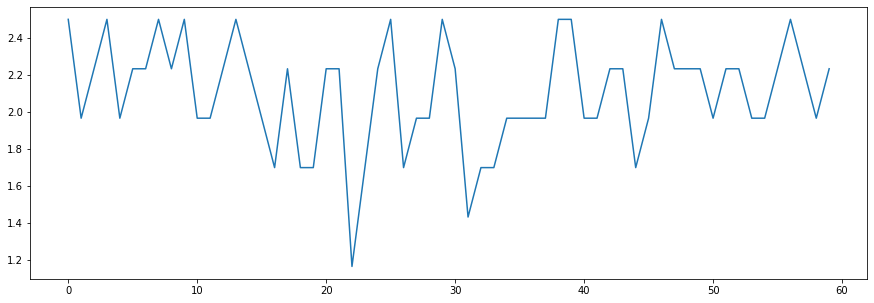

In [247]:
plt.plot(betas1)

5.5136111111111115